In [1]:
import warnings
warnings.filterwarnings("ignore")
import wrangle as w
import functions as f

import pandas as pd
import numpy as np

#splits
from sklearn.model_selection import train_test_split

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import precision_score, accuracy_score, recall_score, classification_report

#model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression


# Project Description

# Project Goal
* Discover drivers of outcome
* Use drivers of outcomes to develop machine learning models to predict outcomes

# Initial Thoughts

* Our initial hypothesis is that the drivers of outcome will be breed, age, condition, species, and sex.

## Acquire
* The data was aquired on `10 July 2023`
* Two datasets downloaded from data.austintexas.gov: [Intake Dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) & [Outcome Dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238)
* Intake Dataset: 153,077 rows and 12 columns 
* Outcome Dataset: 153,449 row and 12 columns
* Each row represents an animal's case
* Each column represents features of the animal

## Prepare
- Two dataframes were created, model_df with encoded variables
- Altered column names for readability, and convenience
- Dropped nulls, duplicate ids, species other than cats and dogs
- Converted data types of various columns to appropriate ones such as 'dates' from string to datetime
- Columns were renamed
- Added Features: sex, breed, condition, outcome_age, rel_month, rel_year, primary_color, is_tabby, mix_color 
- Removed Features: id, name_x, monthyear_x, animal type_x, sex upon intake, age upon outcome, breed_x, color_x, monthyear_y, found location, age upon intake, outcome subtype, intake_datetime, outcome_datetime, outcome_date, intake_date
- Split data into train, validate and test (approx. 60/20/20), stratifying on 'outcome'
- Outliers were not adressed as they were part of the target


In [3]:
# acquire and join dfs
df = w.left_join_csv("austin_animal_outcomes.csv","austin_animal_center_intakes.csv", "df")

In [84]:
df.head()

,dob,outcome,sex,name,intake_type,condition,species,breed,outcome_age,rel_month,rel_year,primary_color,is_tabby,mix_color
0,2017-05-02,adoption,neutered male,1,owner surrender,normal,cat,mix,736,may,2019,brown,1,1
1,2017-07-12,adoption,neutered male,1,stray,normal,dog,mix,371,jul,2018,white,0,1
5,2014-03-12,transfer,intact male,1,stray,medical attention,cat,mix,6,mar,2014,orange,1,0
8,2018-03-01,adoption,neutered male,1,owner surrender,normal,dog,two breeds,797,may,2020,white,0,1
9,2022-05-04,adoption,neutered male,1,stray,normal,cat,mix,76,jul,2022,brown,1,0


In [4]:
#pulling in prepare function from functions.py, creating two dataframes, "df" and "model_df"
df, model_df = w.prep_df(df)

# pre exploration split: train, validate test
train, validate, test = w.split_data(df, 'outcome')

train -> (66040, 14), 60.0%
validate -> (22014, 14),20.0%
test -> (22014, 14), 20.0%


In [27]:
df.to_csv("df.csv")

In [28]:
model_df.to_csv("model_df.csv")

In [29]:
train.to_csv("train.csv")

### Sneak Peak at the Data


In [5]:
# overview of data
train.head()

,dob,outcome,sex,name,intake_type,condition,species,breed,outcome_age,rel_month,rel_year,primary_color,is_tabby,mix_color
64069,2019-05-01,adoption,neutered male,1,stray,normal,cat,mix,112,aug,2019,black,0,1
137739,2014-08-30,other,intact male,1,stray,medical attention,cat,mix,19,sep,2014,brown,1,1
17581,2019-04-06,adoption,neutered male,1,owner surrender,normal,dog,mix,1468,apr,2023,tan,0,1
150725,2013-02-11,adoption,neutered male,1,stray,normal,dog,two breeds,1146,apr,2016,brown,0,1
5361,2020-12-15,adoption,spayed female,1,stray,normal,dog,mix,562,jun,2022,black,0,1


# Exploration

* Confidence Interval: 95%

### Exploratory Questions: 
- What is the Percentage of Dogs and Cats?
- Are Months Related to Dogs/Cats Adoptablility?
- Is Breed Related to Outcome?
- Is Sex Related to Outcome?
- Is Species Related to Outcome?
- Is Condition Related to Outcome
- Is Intake Type Related to Outcome?
- Is Multi-Color Coat Related to Outcome?
- Are Tabby Pattern Coats Related to Outcome?
- Is Primary Coat Color Related to Outcome?

### What is the Percentage of Dogs and Cats?
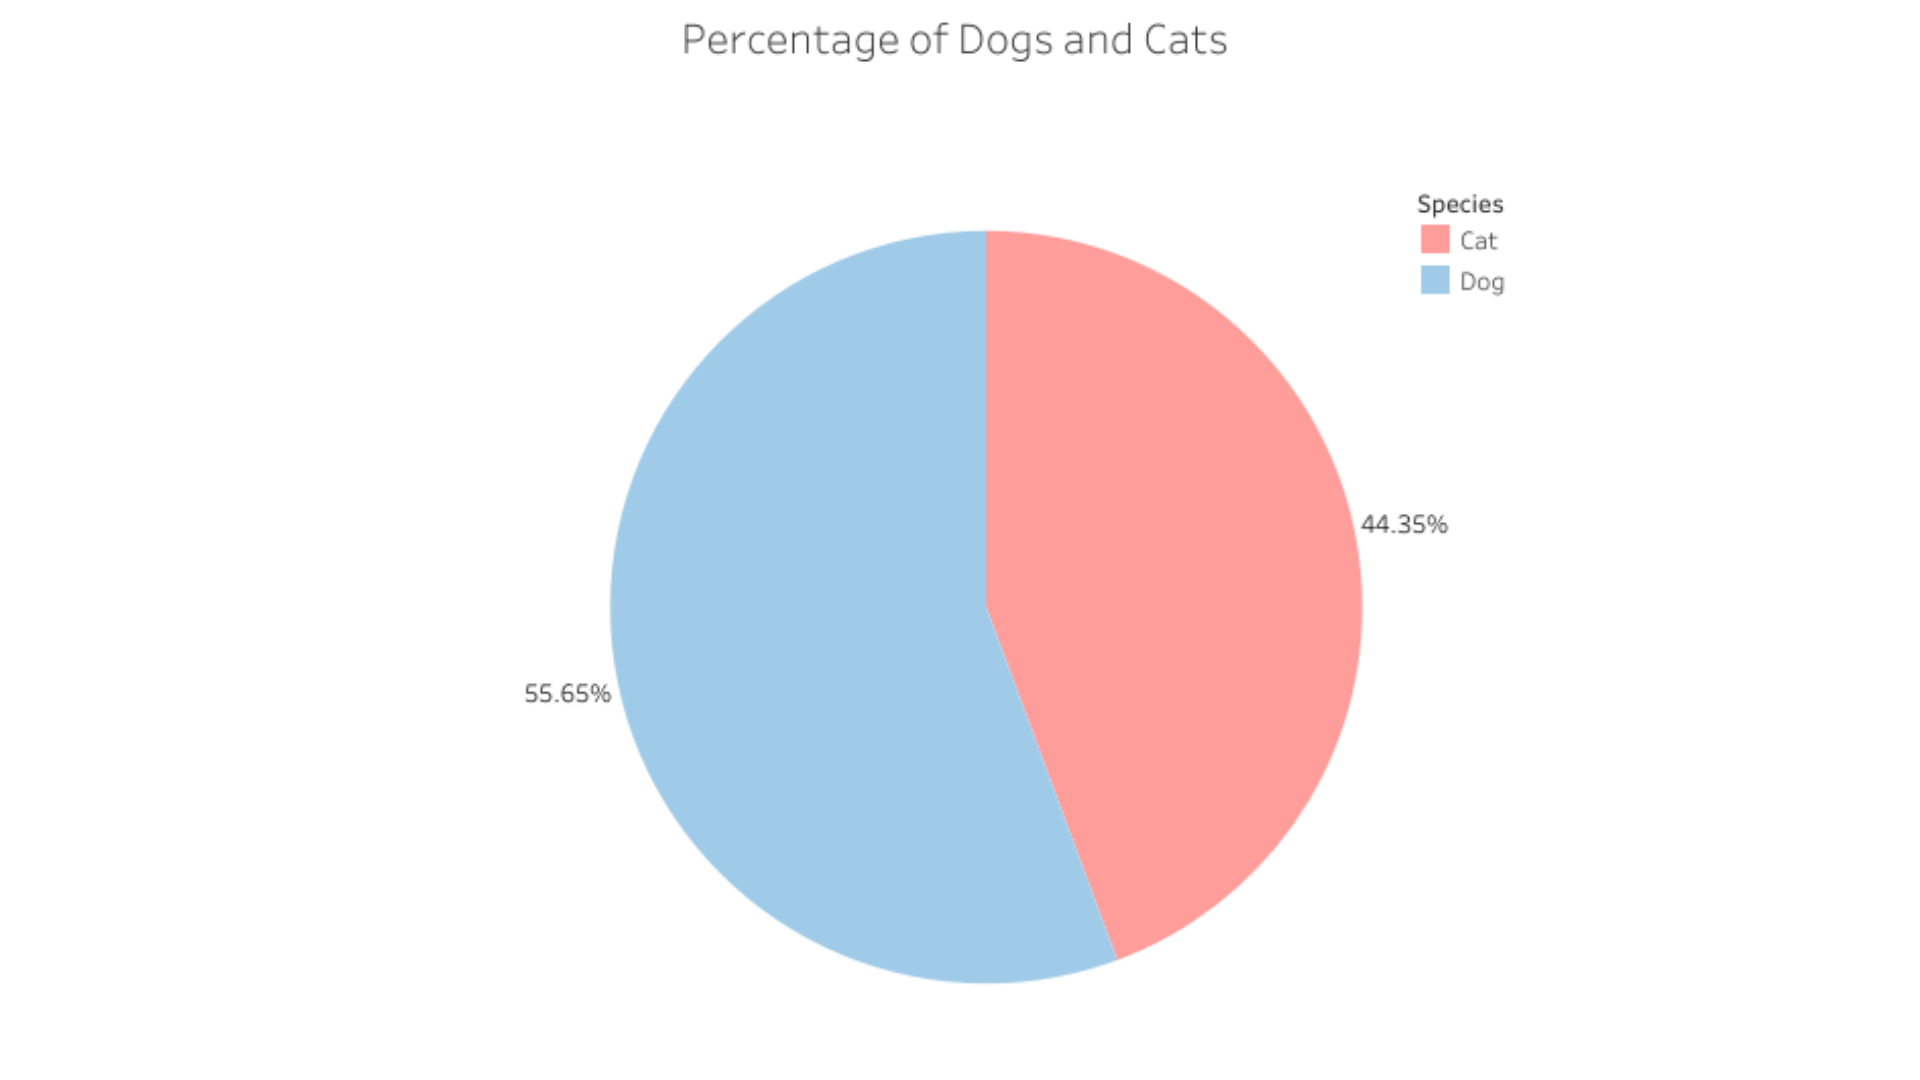

### Percentage of Dogs an Cats that Are Adopted?
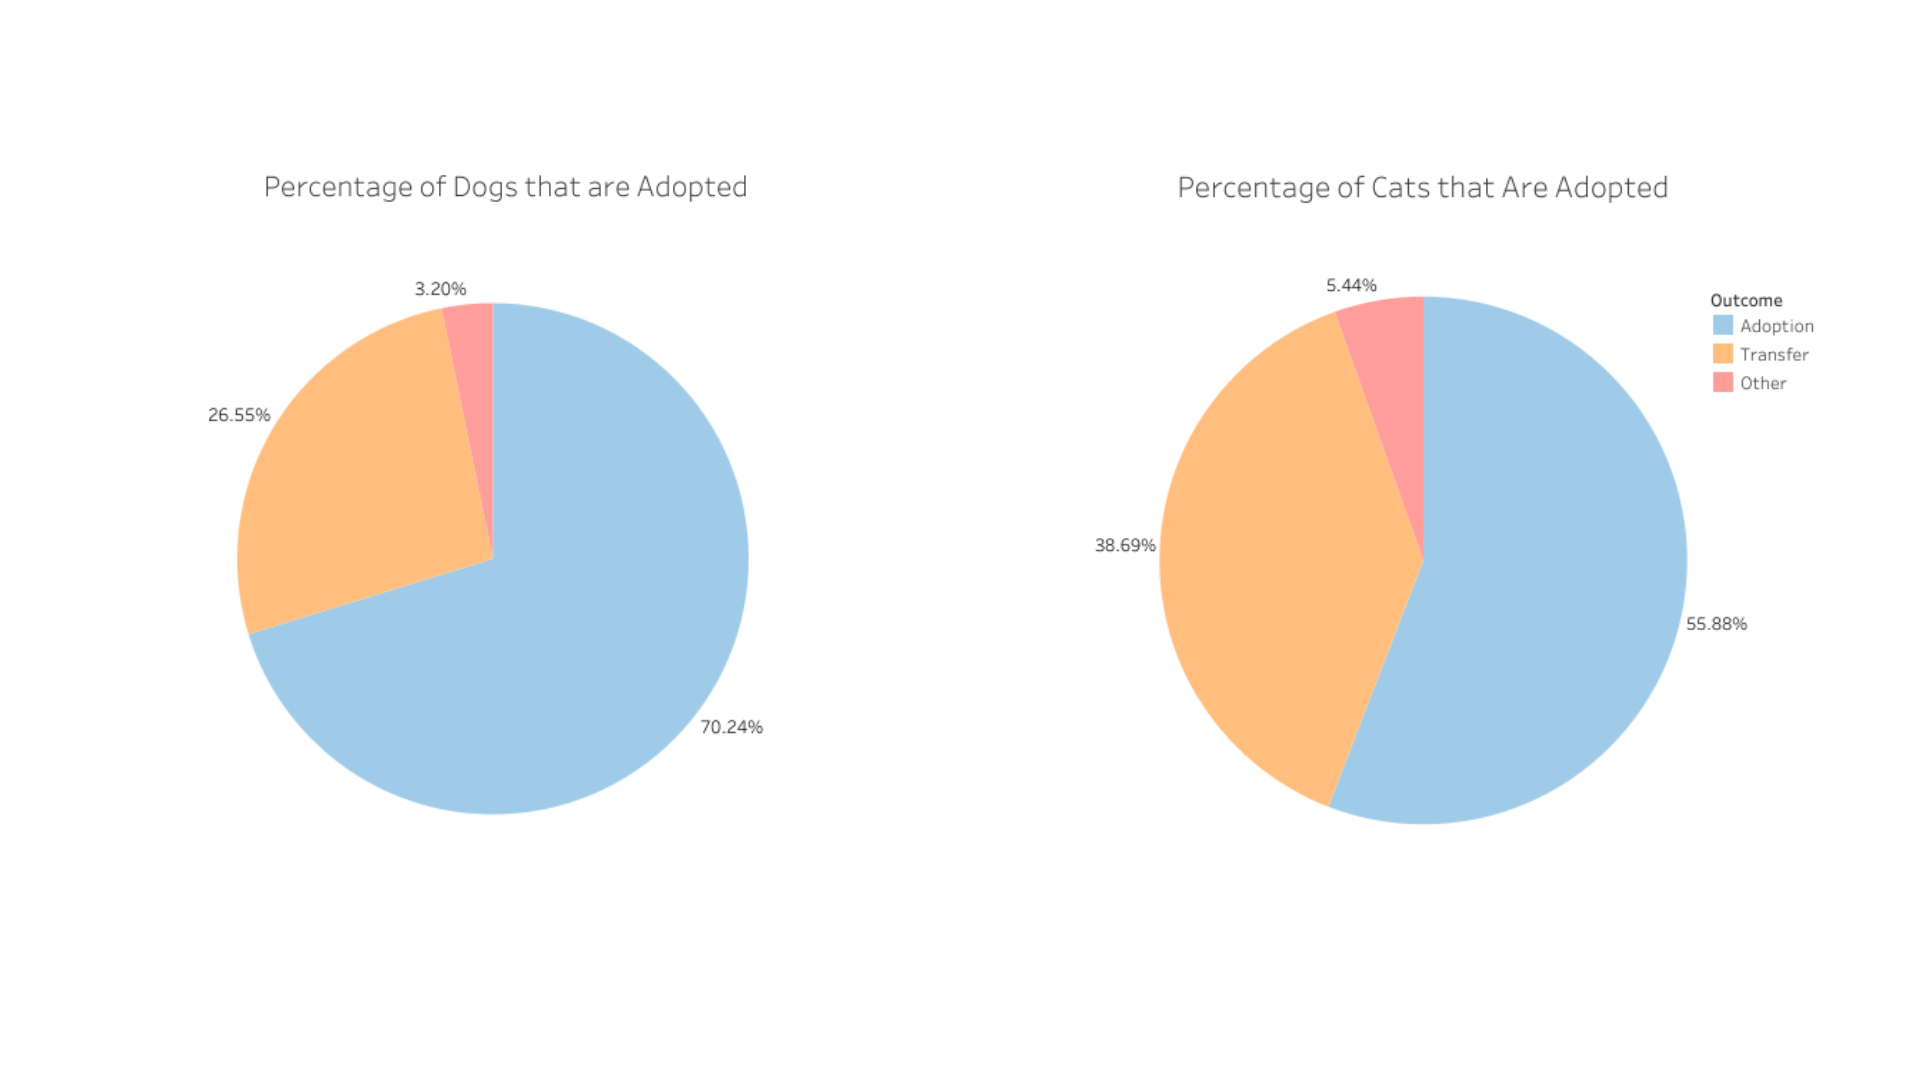

### Q 1. Are Months Related to Dogs/Cats Adoptablility?

* $Ho$ = There is no relationship between cats/dogs months and outcome.
* $Ha$ = There is a relationship between cats/dogs months and outcome.

In [68]:
def month_viz(train, target, title_name):
    '''
    This function pulls in a chart comparing sex and outcome using plotly express
    '''
    month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    train['rel_month'] = pd.Categorical(train['rel_month'], categories=month_order, ordered=True)
    grouped_data = train.groupby(['rel_month', 'outcome']).size().reset_index(name='count')
    grouped_data.sort_values('rel_month', inplace=True)
    fig = px.bar(grouped_data, x='rel_month', y='count', color='outcome', barmode='group')
        # Calculate the total count for each 'rel_month' category
    total_counts = grouped_data.groupby('rel_month')['count'].transform('sum')

    # Calculate the percentage of each 'outcome' category within each 'rel_month' category
    grouped_data['percentage'] = grouped_data['count'] / total_counts * 100

    # Create the stacked bar chart with percentages
    fig = px.bar(grouped_data, x='rel_month', y='percentage', color='outcome', barmode='group',
                 labels={'percentage': 'Total Percentage (%)'})

    # Set x-axis title
    fig.update_xaxes(title_text='Month')
    # Calculate the overall percentage of adoption & transfer line
    overall_adoption_percentage = train[train[target] == 'adoption'].shape[0] / train.shape[0] * 100
    overall_transfer_percentage = train[train[target] == 'transfer'].shape[0] / train.shape[0] * 100
    overall_other_percentage = train[train[target] == 'other'].shape[0] / train.shape[0] * 100
    
    #Add the average line for overall adoption percentage
    fig.add_hline(y=overall_adoption_percentage, line_dash='dash', line_color='blue')

    # Add the average line for overall transferred percentage
    fig.add_hline(y=overall_transfer_percentage, line_dash='dash', line_color='green')
    # Add the average line for overall other percentage
    fig.add_hline(y=overall_other_percentage, line_dash='dash', line_color='red')
    # Set x-axis title
    fig.update_xaxes(title_text="Month")
  # Update layout to set the title
    # Update legend labels
    for trace in fig.data:
        if 'name' in trace:
            trace['name'] = str(trace['name']).capitalize()
        # Add invisible dummy traces to the plot for the legend
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='blue', dash='dash'), name='Avg. Adoption'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='green', dash='dash'), name='Avg. Transferred'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='red', dash='dash'), name='Avg. Other'))
    # Capitalize words in the legend box titles
    fig.update_layout(legend_title_text='Outcome')
    fig.update_layout(title=title_name)  # Update layout to set the title
    fig.show(renderer='png')

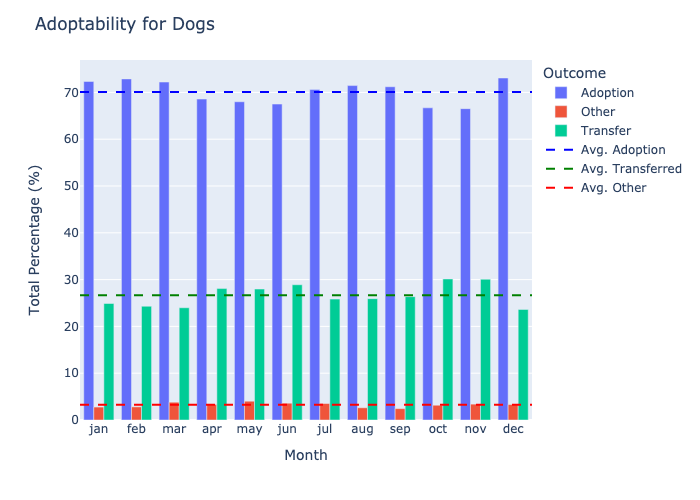

In [69]:
month_viz(dog_mask, "outcome", "Adoptability for Dogs")

In [70]:
f.chi_stats(dog_mask, "rel_month", "outcome")

,Chi-square statistic,p-value,Decision
0,122.697973,5.629724e-16,Reject Null Hypothesis


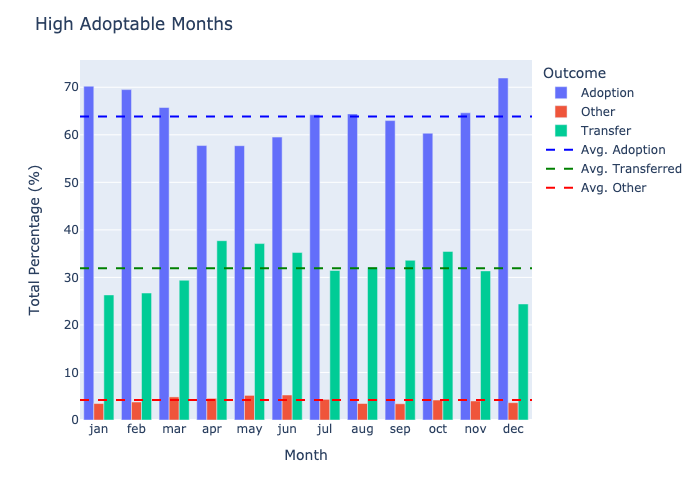

In [72]:
month_viz(train, "outcome", "High Adoptable Months")

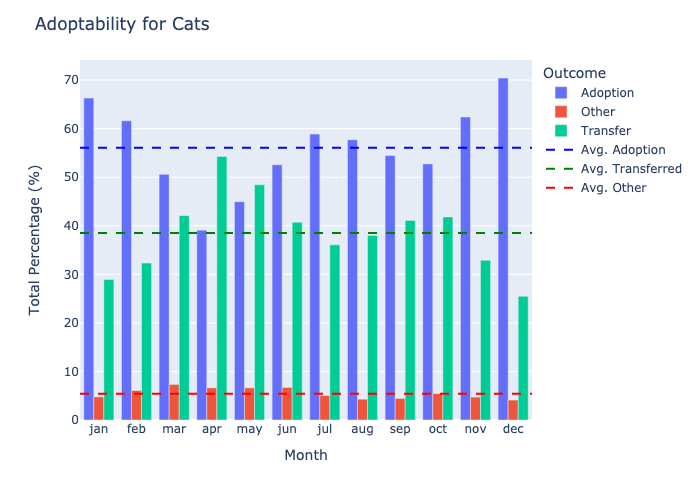

In [73]:
month_viz(cat_mask, "outcome", "Adoptability for Cats")

In [74]:
f.chi_stats(cat_mask, "rel_month", "outcome")

,Chi-square statistic,p-value,Decision
0,756.539653,8.899374e-146,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* Dogs: 
    * There is a higher volumes of adoption occur in December, January, February, and March for dogs.
    * There is a lower volumes of adoption occur in April, May, June, September, October, and November for dogs.
* Cats:
    * There is a higher volumes of adoption occur in December, January, February, July, and August for cats.
    * There is a lower volumes of adoption occur in March, April, May, June, September, and October for cats.

*Based on the result of our test and the observations in the chart, we can infer that month has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q 2. Is Breed Related to Outcome?

* $Ho$ = There is no relationship between breed and outcome.
* $Ha$ = There is a relationship between breed and outcome.

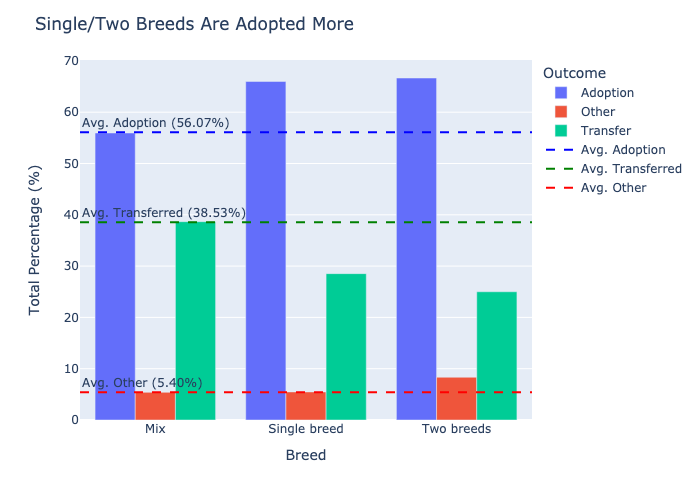

In [78]:
f.px_viz(cat_mask, "breed", "outcome", "Breed", 'Single/Two Breeds Are Adopted More')

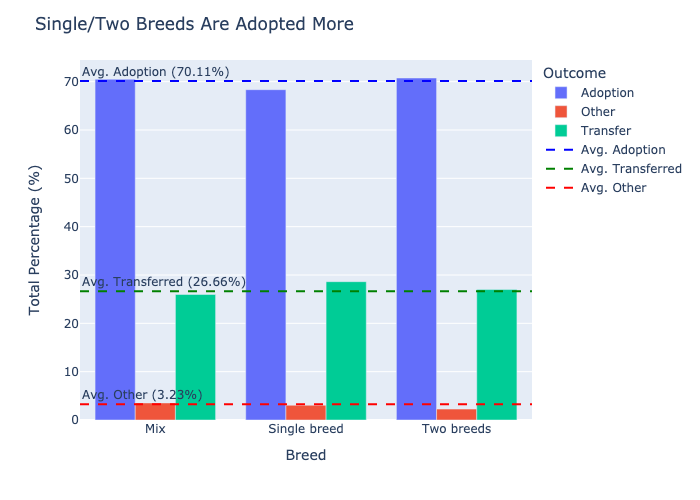

In [79]:
f.px_viz(dog_mask, "breed", "outcome", "Breed", 'Single/Two Breeds Are Adopted More')

In [51]:
f.chi_stats(cat_mask, "breed", "outcome")

,Chi-square statistic,p-value,Decision
0,16.310254,0.00263,Reject Null Hypothesis


In [50]:
f.chi_stats(dog_mask, "breed", "outcome")

,Chi-square statistic,p-value,Decision
0,43.488792,8.192251e-09,Reject Null Hypothesis


In [47]:
f.chi_stats(train, "breed", "outcome")

,Chi-square statistic,p-value,Decision
0,258.839347,8.111347e-55,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* There is a higher volume of mixed breeds that are not adopted or transfered
* Mixed breeds are more likely to be transfered or adopted

*Based on the result of our test and the observations in the chart, we can infer that animal breed  has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q 3  Is Sex Related to Outcome?

* $Ho$ = There is no relationship between sex and outcome.
* $Ha$ = There is a relationship between sex and outcome.

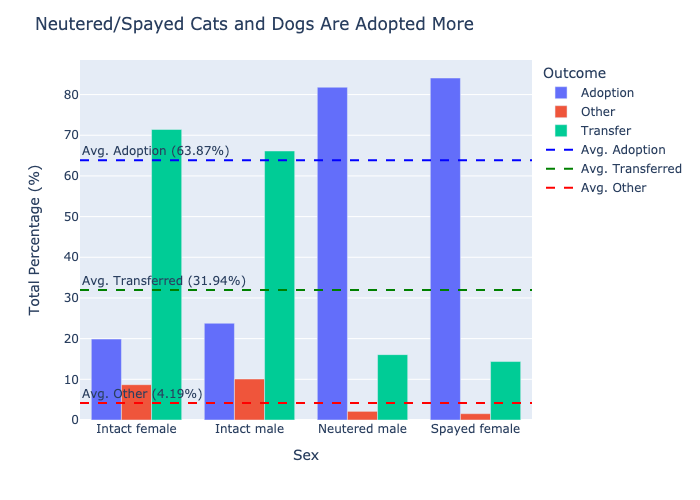

In [10]:
f.px_viz(train, "sex", "outcome", 'Sex', 'Neutered/Spayed Cats and Dogs Are Adopted More')

In [11]:
f.chi_stats(train, "sex", "outcome")

,Chi-square statistic,p-value,Decision
0,23023.75966,0.0,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small.

####  Observations: 
* We can clealy observe a difference in outcomes between intact and fixed animals
    * Fixed animals are far more likely to be adopted
    * This is likly due to the common policy of animal rescues fixing animals before adoption
* Intact males are slightly more likely to have an ‘other’ outcome than intact females
* Intact females are slightly more likely to be transfered than intact males

*Based on the result of our test and the observations in the chart, we can infer that animal sex  has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q4.  Is Species Related to Outcome?

* $Ho$ = There is no relationship between species and outcome.
* $Ha$ = There is a relationship between species and outcome.

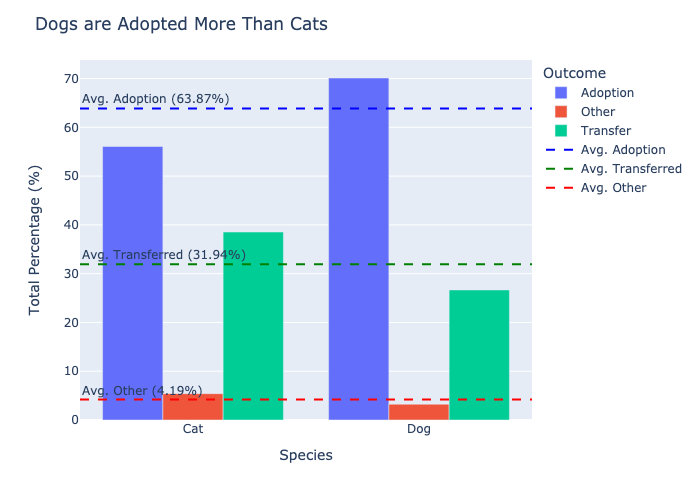

In [12]:
f.px_viz(train, "species", "outcome", 'Species', 'Dogs are Adopted More Than Cats')

In [13]:
f.chi_stats(train, "species", "outcome")

,Chi-square statistic,p-value,Decision
0,1405.711162,5.671523e-306,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* Among dogs a higher percentage were adopted compared to cats
29289 cats, 36758 dogs
    * ~55% of cats were adopted vs ~70% of dogs, while cats more likely to be transfered ~39% for cats, ~27% for dogs
* Cats are slightly more likely to have an ‘other’ or transfer outcome than dogs

*Based on the result of our test and the observations in the chart, we can infer that species type has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q5. Is Condition Related to Outcome?
* $Ho$ = There is no relationship between condition and outcome.
* $Ha$ = There is a relationship between condition and outcome.

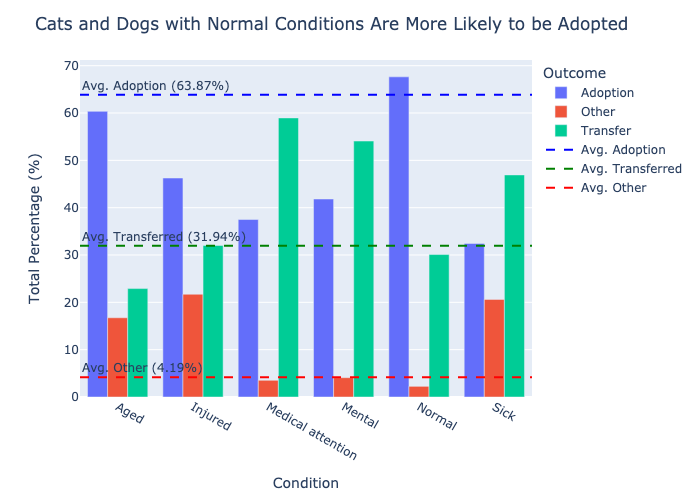

In [14]:
f.px_viz(train, "condition",
         "outcome", 'Condition',
         'Cats and Dogs with Normal Conditions Are More Likely to be Adopted')

In [15]:
f.chi_stats(train, "condition", "outcome")

,Chi-square statistic,p-value,Decision
0,6845.51901,0.0,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies

####  Observations: 
* Cats and dogs with normal conditions are more likely to be adopted.
    * Aminals with conditions such as sick, medical attention, or mental were more likely to be transferred
    `possibly due to outsourcing for medical needs`
    * Injured Cats and dogs are more likely to be adopted.

*Based on the result of our test and the observations in the chart, we can infer that condition has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q6. Is Intake Type Related to Outcome?
* $Ho$ = There is no relationship between intake_type and outcome.
* $Ha$ = There is a relationship between intake_type and outcome.

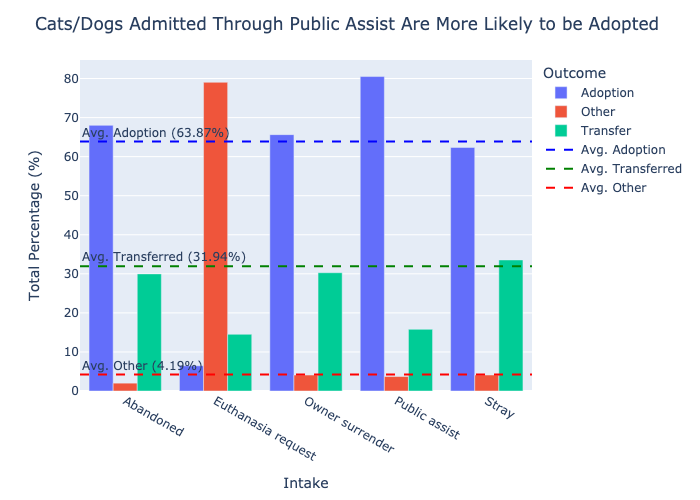

In [17]:
f.px_viz(train, "intake_type",
         "outcome", 'Intake',
         "Cats/Dogs Admitted Through Public Assist Are More Likely to be Adopted")

### Q6.  Is Multi-Color Coat Related to Outcome?

* $Ho$ = There is no relationship between mix_color and outcome.
* $Ha$ = There is a relationship between mix_color and outcome.

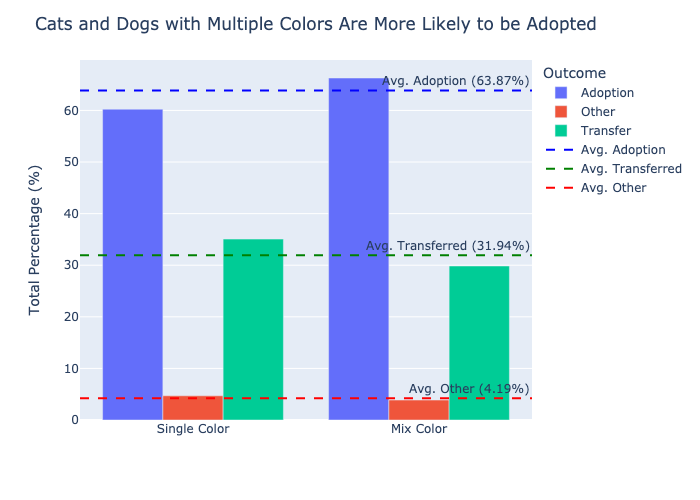

In [18]:
f.px_num_viz(train, 
           "mix_color",
           "outcome", 
           'Cats and Dogs with Multiple Colors Are More Likely to be Adopted', 
           tick_labels=["Single Color", "Mix Color"])

In [19]:
f.chi_stats(train, "mix_color", "outcome")

,Chi-square statistic,p-value,Decision
0,251.848185,2.050508e-55,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies

####  Observations: 
* Cats and dogs with multi-colored coats are more likely to be adopted.
* Cats and dogs with single-colored coats are more likely to be transferred.

**Based on the result of our test and the observations in the chart, we can infer that multi-colored has some correlation to their final outcome. Therefore, we will use this feature in our model.**

### Q7. Are Tabby Cat Patterns Related to Outcome?

* $Ho$ = There is no relationship between is_tabby and outcome.
* $Ha$ = There is a relationship between is_tabby and outcome.

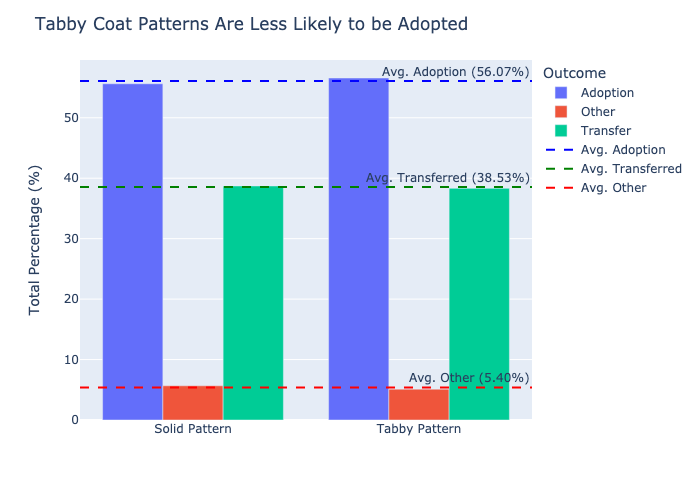

In [20]:
cat_mask = train[train.species == "cat"]
f.px_num_viz(cat_mask, 
           "is_tabby",
           "outcome", 
           'Tabby Coat Patterns Are Less Likely to be Adopted',
           tick_labels=["Solid Pattern", "Tabby Pattern"])

In [21]:
f.chi_stats(cat_mask, "is_tabby", "outcome")

,Chi-square statistic,p-value,Decision
0,5.681031,0.058396,Reject Null Hypothesis


The Chi-squared statistic that there is no substantial difference between the observed and expected frequencies

####  Observations: 
* Tabby Cat patterns are not significant to their outcome. This test was only ran on cats because they were the only species that have a tabby pattern in this data. 

**Based on the result of our test and the observations in the chart, we can infer that a cat's tabby pattern has no correlation to their final outcome. Therefore, this feature will not continue to modeling.**

### Q8.  Is Primary Coat Color For Cats/Dogs Related to Outcome?

* $Ho$ = There is no relationship between primary_color for cats/dogs and outcome.
* $Ha$ = There is a relationship between primary_color for cats/dogs and outcome.

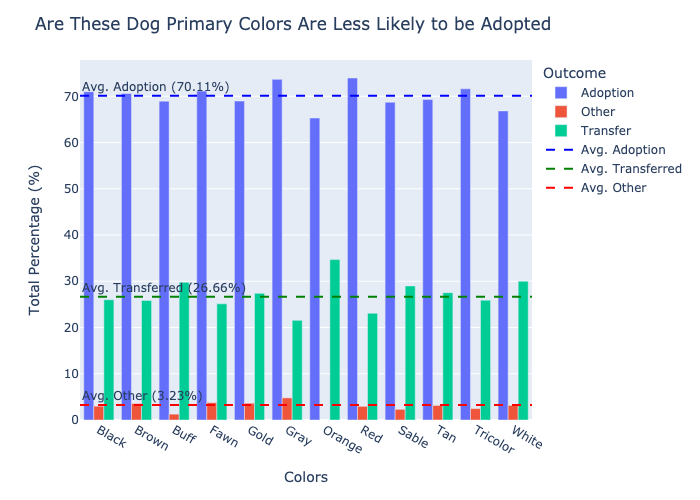

In [22]:
dog_mask = train[train.species == "dog"]
f.px_viz(dog_mask, "primary_color", "outcome", "Colors", 'Are These Dog Primary Colors Are Less Likely to be Adopted')

In [23]:
f.chi_stats(dog_mask, "primary_color", "outcome")

,Chi-square statistic,p-value,Decision
0,124.044501,3.196067e-16,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies

####  Observations: 

 
**Based on the result of our test and the observations in the chart, we can infer that condition has some correlation to their final outcome. Therefore, we will use this feature in our model.**

### Q8.  Is Primary Coat Color For Cats Related to Outcome?

* $Ho$ = There is no relationship between primary_color for cats and outcome.
* $Ha$ = There is a relationship between primary_color for cats and outcome.

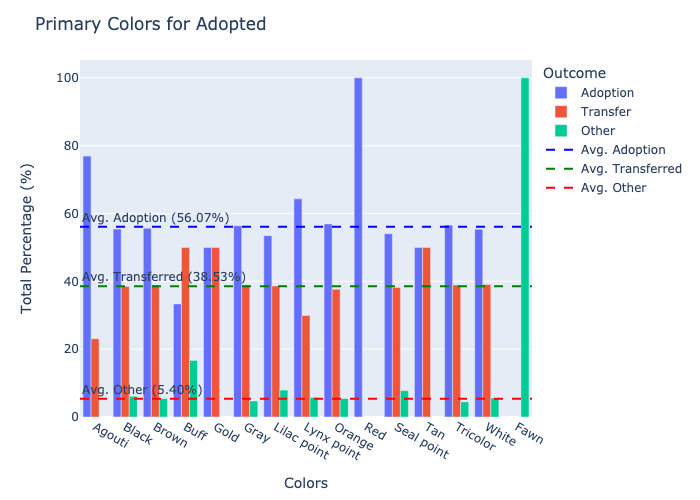

In [24]:
f.px_viz(cat_mask, "primary_color", "outcome", "Colors", "Primary Colors for Adopted")

In [25]:
f.chi_stats(cat_mask, "primary_color", "outcome")

,Chi-square statistic,p-value,Decision
0,65.599437,0.000075,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies

####  Observations: 
* Dog's with the primary color gray and red are more likely to be adopted and will continue to modeling. The remaining colors will also not move to modeling. 
* Cat's with the primary color agouti, lynx point, and red are more likely to be adopted and will continue to modeling. Fawn is a single occurence and and will not be considered for modeling. The remaining colors will also not move to modeling. 
 
**Based on the result of our test and the observations in the chart, we can infer that condition has some correlation to their final outcome. Therefore, we will use this feature in our model.**

## Exploration Summary


# Continuing to Modeling
- Identifed features that have a significant relationship with outcome:
    * June, July, August, and December had higher volumes
    * Mixed breeds are more likely to be transfered or adopted
    * Fixed animals are far more likely to be adopted
    * Cats are slightly more likely to have an ‘other’ or transfer outcome than dogs
    * Cats and dogs with normal conditions are more likely to be adopted.
    
- Month of outcome, Breed of species, Sex, Species, Condition, Mix_color, Month_Rel:
    * Each feature had a statistically significant relaitonship with outcome
    
**We will alter our outcome column by combining `transfer` and `other`, our model will only classify adoption or other**
    
# We did not move forward with the following features: 
* Year_rel: Showed overall trend and would not be a accurate prediction
* Outcome_age: Data integrity issued was raised when we found negative ages
* Is_tabby: Does not have a statisical significance     

## Modeling

- Evaluation Meteric: Accuracy
- Target is outcome
- Baseline: 63.3% (adopted)
- Models will be developed using a few different types, various features, and various hyperparameter configurations
    - KNN
    - Logistic Regression
    - Decision Tree Classifier
    - Random Forest Classifier
    - Support Vector Machine
- Models will be evaluated on Train and Validate
- Best performing model will only be evaluated on Test

In [57]:
model_df = model_df.drop(columns=["is_tabby",'primary_color_brown', 'primary_color_buff', 'primary_color_fawn',
       'primary_color_gold', 'primary_color_lilac point','primary_color_orange', 
       'primary_color_sable', 'primary_color_seal point', 'primary_color_tan',
       'primary_color_tricolor', 'primary_color_white', 'intake_type_owner surrender', 'intake_type_stray'])

In [58]:
model_df.columns

Index(['outcome', 'name', 'mix_color', 'sex_intact male', 'sex_neutered male',
       'sex_spayed female', 'intake_type_euthanasia request',
       'intake_type_public assist', 'condition_injured',
       'condition_medical attention', 'condition_mental', 'condition_normal',
       'condition_sick', 'species_dog', 'breed_single breed',
       'breed_two breeds', 'primary_color_black', 'primary_color_gray',
       'primary_color_lynx point', 'primary_color_red'],
      dtype='object')

In [76]:
# update outcome column to change transfer and other into one and list it as other
model_df.loc[~model_df['outcome'].isin(['adoption']), 'outcome'] = 'other'

# get x and y variables
x_train,y_train,x_validate,y_validate,x_test,y_test = f.get_xy(model_df, "outcome")

train -> (66040, 34), 60.0%
validate -> (22014, 34),20.0%
test -> (22014, 34), 20.0%


In [77]:
# get models - train and validate scores
model_scores = f.get_models(x_train,y_train,x_validate,y_validate)

In [83]:
model_scores

,model,set,accuracy
0,k_nearest_neighbors,train,0.817520
1,k_nearest_neighbors,validate,0.814573
2,logistic_regression,train,0.822093
3,logistic_regression,validate,0.819342
4,DecisionTreeClassifier,train,0.815127
5,DecisionTreeClassifier,validate,0.812574
6,random_forest,train,0.748516
7,random_forest,validate,0.747888
8,support_vector_machine,train,0.824788
9,support_vector_machine,validate,0.822522


# Comparing Models
Baseline: 63.87
* The KNN Model yielded a train accuracy of 79.08 and a validate accuracy of 78.99
* The Logistics Regression Model yielded a train accuracy of 79.46 and a validate accuracy of 79.60
* The Decision Tree Model yielded a train accuracy of 79.06 and a validate accuracy of 79.18
* The Random Forest Model yielded a train accuracy of 71.23 and a validate accuracy of 71.31
* The Support Vector Machine Model yielded a train accuracy of 79.87 and a validate accuracy of 79.78
* The Naive Bayes Model yielded a train accuracy of 67.73 and a validate accuracy of 67.66
* The Gradient Boosting Model yielded a train accuracy of 79.74 and a validate accuracy of 79.76

# Model Selection
* The Gradient Boosting Model maintained a 79.75 % average accuracy with only a 0.02 differential in both train and validate. While most of the models did well with the exception of the Naive Bayes model, there were slight variances between the train and validate sets. We beat the baseline accuracy score of 63.87% by 15.88% when using the average of the Gradient Boosting Model. We will move forward with the Gradient Boosting Model using the final test data set.

In [61]:
f.run_support_vector(x_train, y_train, x_test, y_test)

,model,set,accuracy
0,support_vector,test,0.827019


In [81]:
f.run_gradient_boost(x_train, y_train, x_test, y_test)

,model,set,accuracy
0,gradient_boosting,test,0.799146


# Model Summary
* The Gradient Boost model had a test accuracy score of 79.8%, which is approximately 16% greater than the baseline. 

## Report - Takeaways & Conclusions

### Exploration 
   * Month of outcome, Breed of species, Sex, Species, Condition, Mix_color, Month_Rel had a statistically significant relaitonship with outcome
   * Year_rel and outcome_age did not move to modeling because data integrity was an issue or would not be a accurate prediction.

 
### Recommendations
* During the high adoptions months promote cats, mixed breeds, more by reducing adoption costs, adding stories and character traits.

* Data governance recommendations:
    - We found tens of thousands of rows with data that was missing and/or had nonsensical information
        * Collect more information such as: 
            - Incidents (e.g. biting, abuse hx) 
            - Stated reason for return 
            - Reasons for turn in by owners
            - Vaccination status
            - Who turned the animal in (e.g. citizen, law enforcement, organization)
            - Microchipped
     - Create a database for all animals that are ownded
         * Allow for anyone in the city to register their animals with us whether they are being dropped off or not
         * Collect data on those animals
             * Demographic information
             * Microchip
             * Health conditions
 * Business recommendations:
     - Organize special adoption events and campaigns during the months when dogs and cats are adopted less frequently.
         * Focus on promoting the benefits of adopting during these months, highlighting the joy of having a new furry friend for the upcoming year.
         * Put special emphasis on cats and dogs with single color coats
    - Promotional/Marketing Materials:
        * Highlight the unique qualities and/or advantages of owning:
            - Mixed-breed animals
             - Cats
         * Educating the public about:
             - Responsible pet ownership
                 * The importance of spaying and neutering their pets
                 * Leashes
                 * Microchips
                 * Collaring
                 * Properly securing the animal on their property
             - General benefits of owning a pet
             - The adoption pipeline,
                 * Positive stories
                 * The potential for negative outcomes and stories
                 * Emphasis on stray animals, cause and outcomes
    - Identify any points of friction for the adoption process and smoothen the process, provide support and education along the lifecycle of the animal
    - Partner with local business that would be willing to:
        * Host social events for people who adopted animals from our shelter
        * Allow us to use their store fronts
        * Provide discounts for our customers for a certain period of time if they registered their animal
        * provide discounts for collars, vaccines, microchips, and neutering/spaying for animals purchased, and registered with our shelter


### Next Steps
* If provided more time we would use NLP to review the polarity of the names. 
* Review other shelters with different features
* Research the cause of stray animals